In [1]:
import warnings
warnings.filterwarnings('ignore')

In [338]:
import numpy as np
import pandas as pd

## 1. Load data

In [4]:
file = "data_waiting_time.txt"
data = pd.read_csv(file, header=None, names=['date-time', 'waiting_time'])
data

,date-time,waiting_time
0,20240415-0908,4:54
1,20240416-0910,2:42
2,20240418-0910,3:04
3,20240419-0915,1:39
4,20240429-0901,1:50
5,20240430-0906,1:25
6,20240502-0905,3:37
7,20240503-0908,2:17
8,20240516-0914,1:45
9,20240517-0912,2:12


In [5]:
data.dtypes

date-time       object
waiting_time    object
dtype: object

## 2. Data engineering

In [6]:
# Convert the time into seconds
def to_seconds(x):
    minute, sec = map(float, x.strip().split(':'))
    total_seconds = 60 * minute + sec
    return total_seconds

In [7]:
data['waiting_total_seconds'] = data['waiting_time'].apply(to_seconds)
data

,date-time,waiting_time,waiting_total_seconds
0,20240415-0908,4:54,294.0
1,20240416-0910,2:42,162.0
2,20240418-0910,3:04,184.0
3,20240419-0915,1:39,99.0
4,20240429-0901,1:50,110.0
5,20240430-0906,1:25,85.0
6,20240502-0905,3:37,217.0
7,20240503-0908,2:17,137.0
8,20240516-0914,1:45,105.0
9,20240517-0912,2:12,132.0


## 3. Exploration

In [8]:
data['waiting_total_seconds'].describe()

count     24.000000
mean     137.041667
std       51.498822
min       74.000000
25%      104.500000
50%      129.500000
75%      161.250000
max      294.000000
Name: waiting_total_seconds, dtype: float64

The average time waiting an Ethopia double espresso at Luta during 08:30 - 09:15 is 137 seconds. The minimum waiting time for an Ethopia double espresso during that time is around 74 seconds. The making the double espresso - bean grinding, machine pouring, staff delivering, and etc., takes at least 74 seconds at Luta.

In [231]:
current_waiting_seconds = data['waiting_total_seconds'].values

# Sample mean is a always good start
sample_mean = np.mean(current_waiting_seconds)

sample_var = np.var(current_waiting_seconds, ddof=1)
biased_var = np.var(current_waiting_seconds)

print("Mean of waiting time: {}".format(sample_mean))
print("Sample variance (unbiased estimate): {}".format(sample_var))
print("Biased estimate of variance: {}".format(biased_var))

Mean of waiting time: 137.04166666666666
Sample variance (unbiased estimate): 2652.128623188406
Biased estimate of variance: 2541.623263888889


In [232]:
print("Square of mean: {}".format(sample_mean**2))

Square of mean: 18780.418402777774


In [290]:
exp_var = (sample_mean - min(current_waiting_seconds))**2
print("Shifted exponential distribution variance: {}".format(exp_var))

Shifted exponential distribution variance: 3974.25173611111


There is a discrepancy between the estimated variance (both the sample variance and the biased one) and the variance of the exponential distribution. One possible reason is that my sample size is not large enough. Another possible reason is that the waiting time at a cafe is not perfectly memorless - the probability of waiting longer should be lower when you have been waiting for your coffee for a while.

#### 3.1 Histograms

I try to find a proper probability distribution for the waiting time through visual inspection.

In [291]:
from matplotlib import pyplot as plt
import seaborn as sns

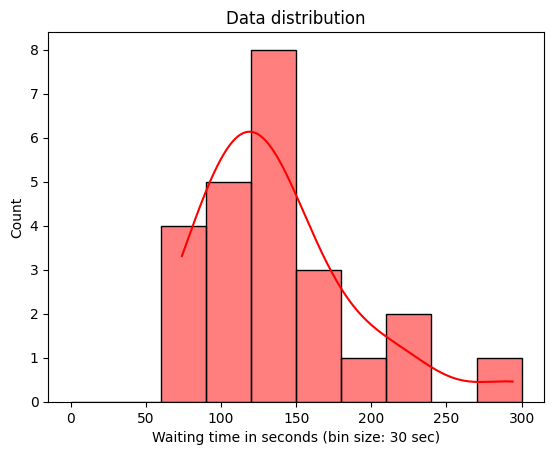

In [394]:
sns.histplot(data=data, x="waiting_total_seconds", binwidth=30, binrange=[0, 300], kde=True, color='red')
plt.xlabel('Waiting time in seconds (bin size: 30 sec)')
plt.title('Data distribution')
plt.savefig("figures/histograms_kde.png", bbox_inches='tight')

The kernel density estimation (KDE) based on the waiting time histogram suggest a **(shifted) exponential distribution** or a **gamma distribution**.

#### 3.2 QQ plot

We can also compare the empirical distribution (sample) with theoretical distribution in quantile-quantile plot (QQ plot).

In [293]:
import scipy.stats as stats
from scipy.stats import norm
from scipy.stats import expon
from scipy.stats import gamma

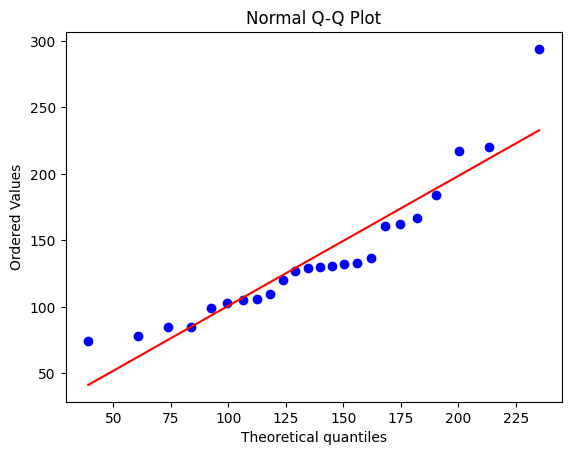

In [294]:
# Normal distribution
stats.probplot(current_waiting_seconds, dist="norm", sparams=(sample_mean, np.sqrt(sample_var)), plot=plt)
plt.title("Normal Q-Q Plot")
plt.show()

Apparently, normal distribution is not suitable for the probability distribution of Luta waiting time. Based on the QQ plot, the probability distribution of Luta waiting time has heavier tails than the normal distribution, and its behaviour is also different around the center (mean).

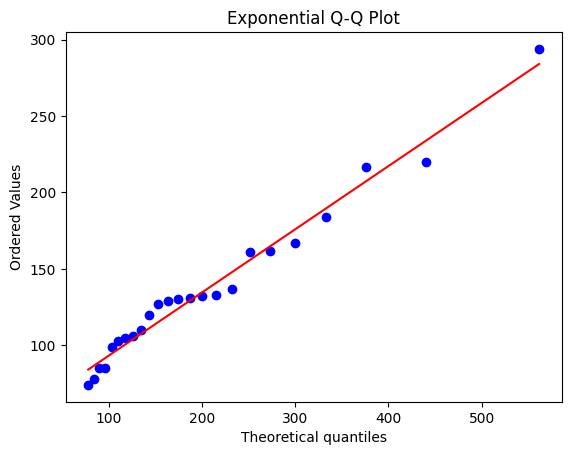

In [295]:
loc, scale = min(current_waiting_seconds), sample_mean
stats.probplot(data['waiting_total_seconds'], dist=expon, sparams=(loc, scale), plot=plt)
plt.title("Exponential Q-Q Plot")
plt.show()

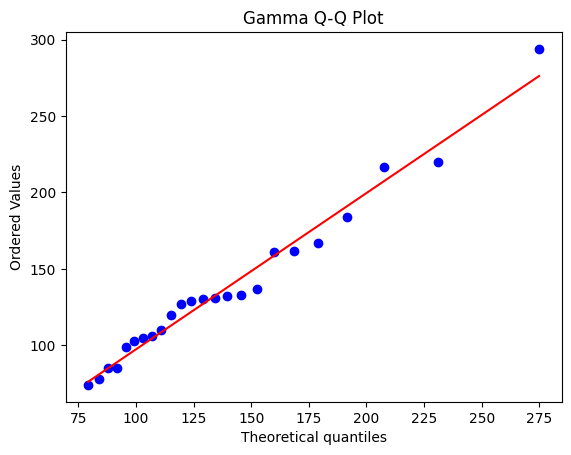

In [296]:
loc = min(current_waiting_seconds)
alpha = (sample_mean - loc)**2 / sample_var
theta = sample_var / (sample_mean - loc)

stats.probplot(data['waiting_total_seconds'], dist=gamma, sparams=(alpha, loc, beta), plot=plt)
plt.title("Gamma Q-Q Plot")
plt.show()

The data seem to distribute like both a gamma distribution and an exponential distribution, though gamma distribution might be a slightly better fit. 

## 4. Fitting

In [251]:
from scipy.stats import gaussian_kde

In [256]:
exp_shift, exp_scale = expon.fit(current_waiting_seconds)

In [257]:
gamma_shape, gamma_shift, gamma_scale = gamma.fit(current_waiting_seconds)

In [258]:
kde = gaussian_kde(current_waiting_seconds)

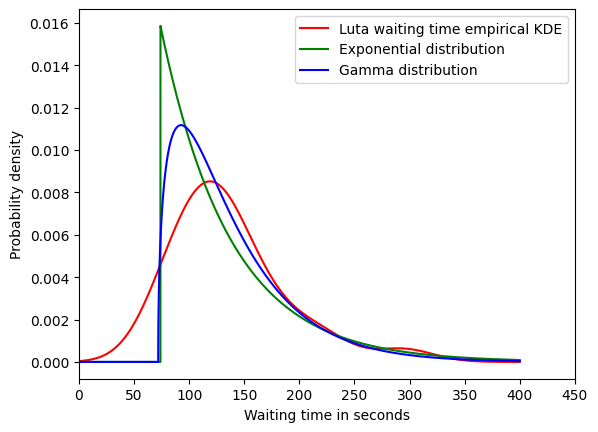

In [259]:
x_points = np.linspace(0, 400, num=10000)

exp_x = expon.pdf(x_points, scale=exp_scale, loc = exp_shift)
gamma_x = gamma.pdf(x_points, a = gamma_shape, loc = gamma_shift, scale = gamma_scale)
kde_x = kde(x_points)

plt.plot(x_points, kde_x, label='Luta waiting time empirical KDE', color='red')
plt.plot(x_points, exp_x,  label='Exponential distribution', color='green')
plt.plot(x_points, gamma_x,  label='Gamma distribution', color='blue')
plt.xlabel('Waiting time in seconds')
plt.ylabel('Probability density')
plt.xlim([0,450])
plt.legend()
plt.savefig("figures/fitting.png", bbox_inches='tight')
plt.show()

The empirical distribution is more similar to a gamma distribution than an exponential distribution. Since gamma distribution has one more parameter than exponential distribution, it is natural that gamma distribution fit the data better than exponential distribution.

#### 4.1 Fitting examination

Now we examine both fittings with Kolmogorov–Smirnov test (K-S test) and Akaike information criterion (AIC)/bayesian information criterion (BIC) model comparison.

In [260]:
__, exp_p_value = stats.kstest(current_waiting_seconds, 'expon', args = (exp_shift, exp_scale))
__, gamma_p_value = stats.kstest(current_waiting_seconds, 'gamma', args = (gamma_shape, gamma_shift, gamma_scale))

In [396]:
exp_scale

63.04166666666666

In [397]:
exp_shift

74.0

In [261]:
print('Exponential-distribution fitting p-value: {}'.format(exp_p_value))
print('Gamma-distribution fitting p-value: {}'.format(gamma_p_value))

Exponential-distribution fitting p-value: 0.5137284528693218
Gamma-distribution fitting p-value: 0.8612276339995868


Both fittings are alright, as the K-S tests provide evidence - both p-values are larger than 5% - to **not reject** the null hypothsis that the data has the same distribution as the exponential distribution/the gamma distribution. 

In [262]:
# The lower, the better
def aic_bic(dist, data, params):
    loglik = np.sum(dist.logpdf(data, *params))
    k = len(params)
    n = len(data)
    aic = 2*k - 2*loglik
    bic = k*np.log(n) - 2*loglik
    return aic, bic

In [264]:
exp_aic, exp_bic = aic_bic(expon, current_waiting_seconds, (exp_shift, exp_scale))
gamma_aic, gamma_bic = aic_bic(gamma, current_waiting_seconds, (gamma_shape, gamma_shift, gamma_scale))

In [265]:
print('Exponential-distribution fitting AIC: {}'.format(exp_aic))
print('Gamma-distribution fitting AIC: {}'.format(gamma_aic))

Exponential-distribution fitting AIC: 250.90220240513972
Gamma-distribution fitting AIC: 252.5185839095463


In [266]:
print('Exponential-distribution fitting BIC: {}'.format(exp_bic))
print('Gamma-distribution fitting BIC: {}'.format(gamma_bic))

Exponential-distribution fitting BIC: 253.25831006583562
Gamma-distribution fitting BIC: 256.05274540059014


- Both exponential distribution and gamma distribution fit the data reasonably well, though it tells gamma distribution fits slightly better by both the visualization and p-values.

- However, the exponential distribution has smaller AIC/BIC - though the difference is statistically negeligible. This is because exponential distribution has smaller number of parameters than gamma distribution. AIC and BIC give penalty on model complexity to prevent the model from overfitting.

- Therefore, it is actually hard to decide which distribution works better on the Luta waiting time.

- Since the exponential distribution is simpler, I will use the exponential distribution for the following Bayesian framework.

## 5. Bayesian framework

#### Assign a proper prior

- Since the **conjugate prior** of exponential distribution is gamma distribution, I will use **gamma distribution for prior**.

- To build the bayesian framework upon the above analysis, I want the **mode** of this gamma prior to be the shifted mean of the fitted exponential distribution, 1/exp_scale, the **reciprocal of the fitted exponential distribution's scale**.

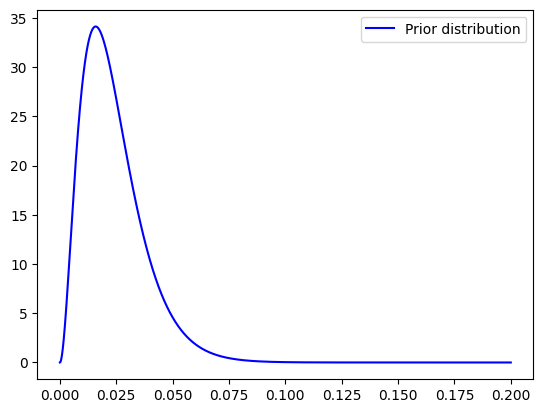

In [272]:
# Prior
prior_alpha = 3
prior_theta = 1 / (exp_scale * (prior_alpha - 1))

x_points = np.linspace(0.000001, 0.2, num=15000)

prior_gamma = gamma.pdf(x_points, a = prior_alpha, loc = 0, scale = prior_theta)
plt.plot(x_points, prior_gamma,  label='Prior distribution', color='blue')
plt.legend()
plt.show()

The prior looks fine.

#### Update data 

In [316]:
update_waiting_time = [87, 147, 130] # an example

#### Bayesian estimation

With the updated waiting time, we can now calculate the posterior and estimate the scale of the exponential distribution for Luta waiting time. We have two estimators for the scale of the exponential distribution, the **posterior mean** and **Maximum a posteriori (MAP)**.

***Note:*** Although we can easily get the posterior distribution, posterior mean, and MAP through the property of conjugate prior, I manually calculate them in the following snippet. One can follow the snippet to compute their posterior distribution, posterior mean, and MAP even their prior is not the conjugate prior. 

In [334]:
# General computation
x_points = np.linspace(0.000001, 0.2, num=15000)

step_size = (0.2 - 0.000001)/15000

denom_sum = 0
numer_sum = 0

posterior = []

maximum_posteriori = x_points[0]
temp = np.prod(expon.pdf(update_waiting_time, loc = 0, scale = 1 / maximum_posteriori)) * \
       gamma.pdf(maximum_posteriori, a = prior_alpha, loc = 0, scale = prior_theta)

for point in x_points:
    moving_prior = gamma.pdf(point, a = prior_alpha, loc = 0, scale = prior_theta)
    moving_likelihood = math.prod(expon.pdf(update_waiting_time, loc = 0, scale = 1 / point))

    posterior.append(moving_likelihood * moving_prior)

    numer_sum += point * moving_likelihood * moving_prior * step_size
    denom_sum += moving_prior * moving_likelihood * step_size

    if moving_likelihood * moving_prior > temp:
        maximum_posteriori = point
        temp = moving_likelihood * moving_prior

# Updated prior distribution
posterior = posterior / denom_sum

# Bayesian estimator
posterior_mean = numer_sum / denom_sum
bays_scale = 1 / posterior_mean

# MAP
map_scale = 1 / maximum_posteriori

#### Posterior by conjugate

By the property of conjugate prior, the posterior is also a gamma distribution. Its shape parameter equals the sum of the gamma prior shape and the sample size of the observed data, while its rate parameter (the reciprocal of the scale) equals the sum of the gamma prior rate and the total (sum) of the observed data.

In [318]:
update_alpha = prior_alpha + len(update_waiting_time)
prior_beta = 1 / prior_theta
update_beta = prior_beta + sum(update_waiting_time)
update_theta = 1 / update_beta

In [328]:
theoretical_post = gamma.pdf(x_points, a = update_alpha, loc = 0, scale = update_theta)

theoretical_mean = update_alpha * update_theta
theoretical_mode = (update_alpha - 1) * update_theta

print("Posterior mean by conjugate property: {}".format(theoretical_mean))
print("Posterior mean by manual calculation: {}".format(posterior_mean))

print("MAP by conjugate property: {}".format(theoretical_mode))
print("MAP by manual calculation: {}".format(maximum_posteriori))

Posterior mean by conjugate property: 0.012242815847644958
Posterior mean by manual calculation: 0.012242815847644977
MAP by conjugate property: 0.010202346539704133
MAP by manual calculation: 0.010201629041936128


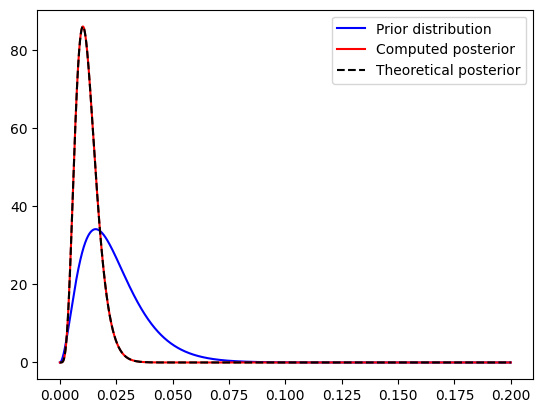

In [330]:
plt.plot(x_points, prior_gamma,  label='Prior distribution', color='blue')
plt.plot(x_points, posterior,  label='Computed posterior', color='red')
plt.plot(x_points, theoretical_post,  label='Theoretical posterior', color='black', linestyle = '--')
plt.legend()
plt.savefig("figures/prior_posterior.png", bbox_inches = "tight")
plt.show()

- The manual computation agree with the computation by the property of conjugate prior, but the latter is much easier.

- The gamma posterior becomes narrower than the gamma prior. This is because the newly observed waiting times make the prior belief more informative.

- The newly observed waiting waiting time also suggest a smaller value for the parameter of the exponential distribution (i.e. larger `exp_scale`), indicating a longer average waiting time for Ethopia double espresso at Luta.

#### Updated waiting time distribution

In [339]:
update_data = np.concatenate((current_waiting_seconds, np.array(update_waiting_time)))
update_kde = gaussian_kde(update_data)

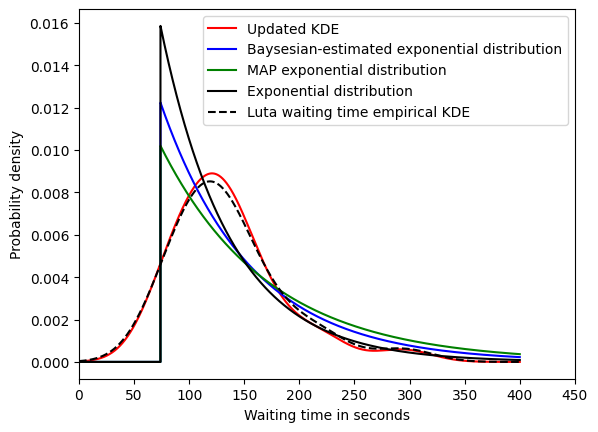

In [348]:
update_shift = min(exp_shift, min(update_waiting_time))

x_points = np.linspace(0, 400, num=10000)

bays_exp_x = expon.pdf(x_points, scale = bays_scale, loc = update_shift)
map_exp_x = expon.pdf(x_points, scale = map_scale, loc = update_shift)
update_kde_x = update_kde(x_points)
exp_x = expon.pdf(x_points, scale = exp_scale, loc = exp_shift)
kde_x = kde(x_points)

plt.plot(x_points, update_kde_x, label='Updated KDE', color='red')
plt.plot(x_points, bays_exp_x,  label='Baysesian-estimated exponential distribution', color='blue')
plt.plot(x_points, map_exp_x,  label='MAP exponential distribution', color='green')
plt.plot(x_points, exp_x,  label='Exponential distribution', color='black')
plt.plot(x_points, kde_x,  label='Luta waiting time empirical KDE', color='black', linestyle='--')
plt.xlabel('Waiting time in seconds')
plt.ylabel('Probability density')
plt.xlim([0,450])
plt.legend()
plt.savefig("figures/waiting_time_update.png", bbox_inches='tight')
plt.show()

- The updated empirical KDE (red) shift toward the right because the newly observed waiting times suggest longer waiting time.

- Instead of being fitted as a fixed exponential distribution (black), ***the distribution of the waiting time is updated to exponential distribution of different parameters estimated by the bayesian framework.***

In [391]:
# 95% confidence interval of the exponential distribution parameter, lambda
lambda_ci = gamma.ppf([0.025, 0.975], a=update_alpha, scale=update_theta)
print("95% credible region of the exponential distribution parameter: {}".format(lambda_ci))

95% credible region of the exponential distribution parameter: [0.0044929  0.02380887]


In [392]:
average_time_ci = (74*lambda_ci[::-1]+1)/lambda_ci[::-1]
print("95% Bayesian credible region of average waiting time: {}".format(average_time_ci))

95% Bayesian credible region of average waiting time: [116.00114721 296.57351031]


Now we compare the Bayesian confidence region with the frequentist's confidence interval. To get the updated frequentist's confidence interval, we need to update data with the newly observing times and refit.

In [387]:
refit_shift, refit_scale = expon.fit(update_data)
refit_ci = expon.ppf([0.025, 0.975], loc = refit_shift, scale = refit_scale)
print("95% frequentist confidence interval of waiting time: {}".format(refit_ci))

95% frequentist confidence interval of waiting time: [ 75.55188786 300.11464802]


In [388]:
expon.ppf([0.025, 0.975], loc = exp_shift, scale = exp_scale)

array([ 75.59607681, 306.55310892])

Our 95% Bayesian credible region of average waiting time is narrower than the 95% frequentist confidence interval of average waiting time without shifting away from it. This is because our choice of prior, gamma distribution with parameters pre-decided by the 24 observed waiting times, is not only informative but also aligned with the observed data. 

#### Update prior belief and prepare for upcoming observed data

The following snippet is for the ***next Bayesian estimation***.
One can uncomment the following code to update the prior with the posterior calculated above and input the newly observed data.

In [ ]:
""" # Update Prior
prior_alpha = update_alpha
prior_theta = update_theta

# Update Data
current_waiting_seconds = update_data
update_waiting_time = [] # input newly observed data here
"""